TransferLearning e FineTuning di una SqueezeNet sul datatset della hands digit recignition. I parametri sono precedentemente stati trainati su 'ImageNet'.

https://www.kaggle.com/kmader/food-squeezenet

In [ ]:
#%cd
#shutil.rmtree('/content/hands_dataset', ignore_errors=True) #non usarloo

In [ ]:
!pip install keras_applications

     |████████████████████████████████| 51kB 6.8MB/s 


In [ ]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D,  BatchNormalization, InputLayer
from keras.models import Model
from keras.engine.topology import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils
import keras
from keras.callbacks import ModelCheckpoint




import numpy as np
import math
import tensorflow as tf


#import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from math import ceil
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import itertools
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings

In [ ]:
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(input_tensor=None, input_shape=None,
               weights='imagenet',
               classes=1000,
              use_bn_on_input = False, # to avoid preprocessing
               first_stride = 2
              ):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                     require_flatten = False)

    if input_tensor is None:
        raw_img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if use_bn_on_input:
        img_input = BatchNormalization()(raw_img_input)
    else:
        img_input = raw_img_input


    x = Convolution2D(64, (3, 3), strides=(first_stride, first_stride), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    out = Activation('softmax', name='loss')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = raw_img_input

    model = Model(inputs, out, name='squeezenet')

    # load weights
    if weights == 'imagenet':

        weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

##TEST 1: training da inizializzazione casuale e senza Augmentation
(classic_model)

In [ ]:
model = SqueezeNet(input_shape = (224,224,3), weights = None, classes = 10,
                  use_bn_on_input = True)
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-7)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "squeezenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 111, 111, 64) 1792        batch_normalization[0][0]        
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 111, 111, 64) 0           conv1[0][0]                      
_________________________________________________________________________________________

In [ ]:
%cd 
%cd ../content
!pwd

/root
/content
/content


In [ ]:

!pwd

!git clone https://github.com/tesiiscomingson/hands_dataset.git

/content
Cloning into 'hands_dataset'...
remote: Enumerating objects: 2696, done.
remote: Total 2696 (delta 0), reused 0 (delta 0), pack-reused 2696
Receiving objects: 100% (2696/2696), 22.06 MiB | 41.15 MiB/s, done.
Resolving deltas: 100% (863/863), done.


In [ ]:
%cd hands_dataset
!ls


/content/hands_dataset
Dataset  Examples  LICENSE  README.md


In [ ]:
!rm -rf Examples  LICENSE  README.md
!ls

Dataset


In [ ]:
dir_path = os.path.dirname(os.path.realpath('FT_mobilenet.ipynb'))
print(dir_path)

/content/hands_dataset


In [ ]:
!pwd

/content/hands_dataset


In [ ]:
%cd /content/hands_dataset/Dataset
%mkdir train
%mkdir test
%mkdir valid
%mv 0/ 1/ 2 / 3/ 4/ 5/ 6/ 7/ 8/ 9/ train/

/content/hands_dataset/Dataset
mv: cannot move '/' to 'train': Device or resource busy


In [ ]:
#%cd -
!pwd
%cd valid
%mkdir 0/ 1/ 2 / 3/ 4/ 5/ 6/ 7/ 8/ 9/
%cd ../test
%mkdir 0/ 1/ 2 / 3/ 4/ 5/ 6/ 7/ 8/ 9/

/content/hands_dataset/Dataset
/content/hands_dataset/Dataset/valid
mkdir: cannot create directory ‘/’: File exists
/content/hands_dataset/Dataset/test
mkdir: cannot create directory ‘/’: File exists


In [ ]:

!pwd

/content/hands_dataset/Dataset/test


In [ ]:
%%bash
cd ../train
for ((i=0; i<=9; i++)); do
  a=$(find $i/ -type f | shuf -n 30)
  mv $a ../valid/$i/
  b=$(find $i/ -type f | shuf -n 5)
  mv $b ../test/$i/
done


In [ ]:
%cd ../..
!pwd

/content/hands_dataset
/content/hands_dataset


In [ ]:
train_path = 'Dataset/train'
valid_path = 'Dataset/valid'
test_path = 'Dataset/test'  

In [ ]:
b_size=16

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path, target_size=(224, 224), batch_size=b_size)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path, target_size=(224, 224), batch_size=b_size)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path, target_size=(224, 224), batch_size=b_size, shuffle=False)

Found 2172 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [ ]:
metrics = ['accuracy']

In [ ]:
train_steps=ceil(2172/b_size)
valid_steps=ceil(300/b_size)

In [ ]:
history = model.fit_generator(train_batches, steps_per_epoch=train_steps,validation_data=valid_batches, validation_steps=valid_steps,epochs=50, verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
136/136 - 42s - loss: 2.3028 - accuracy: 0.0889 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/50
136/136 - 6s - loss: 2.3027 - accuracy: 0.0976 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/50
136/136 - 6s - loss: 2.3028 - accuracy: 0.1013 - val_loss: 2.3023 - val_accuracy: 0.1000
Epoch 4/50
136/136 - 6s - loss: 2.2972 - accuracy: 0.0999 - val_loss: 2.3055 - val_accuracy: 0.0967
Epoch 5/50
136/136 - 6s - loss: 2.2888 - accuracy: 0.0994 - val_loss: 2.2855 - val_accuracy: 0.0800
Epoch 6/50
136/136 - 6s - loss: 2.2691 - accuracy: 0.1105 - val_loss: 2.2488 - val_accuracy: 0.1133
Epoch 7/50
136/136 - 6s - loss: 2.2143 - accuracy: 0.1344 - val_loss: 2.1107 - val_accuracy: 0.2333
Epoch 8/50
136/136 - 6s - loss: 2.1031 - accuracy: 0.1750 - val_loss: 2.3106 - val_accuracy: 0.1433
Epoch 9/50
136/136 - 6s - loss: 2.0402 - accuracy: 0.2058 - val_loss: 1.9348 - val_accuracy: 0.2333
Epoch 10/50
136/136 - 6s - loss: 1.9545 - accuracy: 0.2362 - val_loss: 1.8570 - val_accuracy: 0.330

In [ ]:
def sum_up(history): 
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()

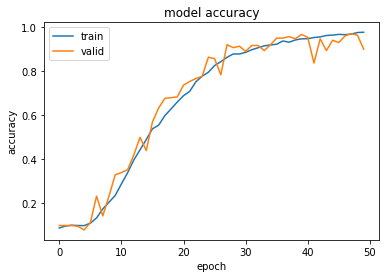

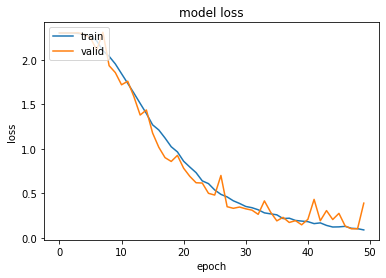

In [ ]:
sum_up(history)


In [ ]:
model.save('classic_squeeze.h5')

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
test_labels = test_batches.classes
predictions = model.predict_generator(test_batches, steps=ceil(50/b_size), verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 1 4 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 1 3 1]
 [0 0 0 0 0 0 1 1 0 3]]


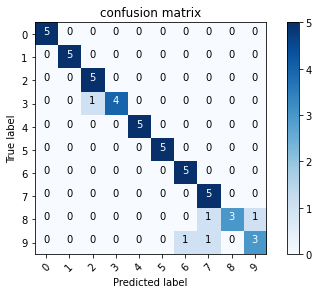

In [ ]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm, cm_plot_labels, title='confusion matrix')

Nonostante l'apparente successo in fase di test con webcam la rete oscilla sempre tra zero e uno. Potrebbe significare che è in grado di riconoscere solo immagini simili al dataset su cui è avvenuto il training, proviamo con un nuovo modello con Augmentation.

In [ ]:
ft_model = SqueezeNet(input_shape = (224,224,3), weights = 'imagenet', classes = 1000,
                  use_bn_on_input = False)

5062656/5059384 [==============================] - 0s 0us/step


In [ ]:
ft_model.summary()

Model: "squeezenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 111, 111, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 111, 111, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 55, 55, 64)   0           relu_conv1[0][0]                 
_________________________________________________________________________________________

In [ ]:
x = Sequential()
x = ft_model.layers[-6].output
# we take out only the last 4 layers


In [ ]:
x = (Convolution2D(10, (1, 1), padding='valid', name='conv10'))(x)
x = (Activation('relu', name='relu_conv10'))(x)
x = (GlobalAveragePooling2D())(x)
pred = (Activation('softmax', name='loss'))(x)
new_model = Model(inputs=ft_model.input, outputs=pred)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 111, 111, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 111, 111, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 55, 55, 64)   0           relu_conv1[0][0]                 
______________________________________________________________________________________________

In [ ]:
for layer in new_model.layers[:-25]:
  layer.trainable = False

new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 111, 111, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 111, 111, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 55, 55, 64)   0           relu_conv1[0][0]                 
______________________________________________________________________________________________

In [ ]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-7)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)
# Let's train the model using RMSprop
new_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history =  new_model.fit_generator(train_batches, steps_per_epoch=train_steps,validation_data=valid_batches, validation_steps=valid_steps,epochs=35, verbose=2, callbacks=mc)

Epoch 1/35


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


136/136 - 7s - loss: 2.2753 - accuracy: 0.2164 - val_loss: 1.9642 - val_accuracy: 0.3400
Epoch 2/35
136/136 - 6s - loss: 1.5509 - accuracy: 0.5331 - val_loss: 0.9755 - val_accuracy: 0.7400
Epoch 3/35
136/136 - 6s - loss: 0.7622 - accuracy: 0.7661 - val_loss: 0.5080 - val_accuracy: 0.8867
Epoch 4/35
136/136 - 6s - loss: 0.4787 - accuracy: 0.8614 - val_loss: 0.4201 - val_accuracy: 0.8633
Epoch 5/35
136/136 - 6s - loss: 0.3328 - accuracy: 0.9102 - val_loss: 0.3176 - val_accuracy: 0.8933
Epoch 6/35
136/136 - 6s - loss: 0.2500 - accuracy: 0.9300 - val_loss: 0.1916 - val_accuracy: 0.9500
Epoch 7/35
136/136 - 6s - loss: 0.2037 - accuracy: 0.9369 - val_loss: 0.1784 - val_accuracy: 0.9400
Epoch 8/35
136/136 - 6s - loss: 0.1765 - accuracy: 0.9475 - val_loss: 0.2618 - val_accuracy: 0.8900
Epoch 9/35
136/136 - 6s - loss: 0.1365 - accuracy: 0.9627 - val_loss: 0.0907 - val_accuracy: 0.9800
Epoch 10/35
136/136 - 6s - loss: 0.1306 - accuracy: 0.9604 - val_loss: 0.1173 - val_accuracy: 0.9667
Epoch 11/3

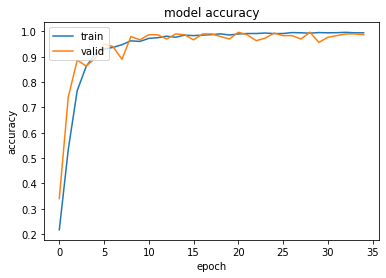

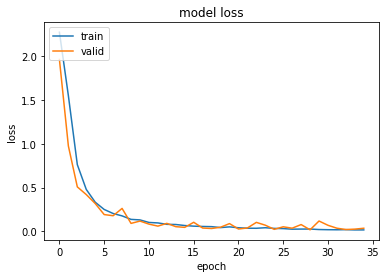

In [ ]:
sum_up(history)

In [ ]:
test_labels = test_batches.classes
predictions = new_model.predict_generator(test_batches, steps=ceil(50/b_size), verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 4 1 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


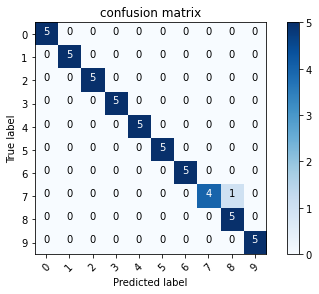

In [ ]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm, cm_plot_labels, title='confusion matrix')